In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
np.random.seed(0)

# Data import

In [2]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,109.103,61.177,76.58000,59.290,0.000,0.000,0.000,3.135,17.427000,...,0.000000,0.00000,27.755,20.293108,-25.913437,32.415176,41.500,1.0,1,0.000027
1,1,181.342,70.254,127.00599,2.171,0.000,0.000,0.000,3.494,2.171001,...,0.000000,0.00000,57.260,89.156906,-21.388142,-3.724448,21.710,0.0,0,0.000169
2,2,103.283,17.708,69.48400,67.527,0.000,0.000,0.000,2.436,24.891000,...,0.000000,0.00000,50.464,94.160360,26.598667,13.211420,29.699,1.0,0,0.000051
3,3,103.834,21.393,43.52400,312.742,0.715,245.986,0.134,0.674,56.143000,...,61.189460,-109.27732,49.068,116.437960,179.089020,41.177580,183.762,3.0,0,0.000009
4,4,92.636,21.026,60.84300,150.233,4.067,482.888,-3.070,1.284,16.861000,...,11.334548,-434.68580,64.211,234.337980,53.694386,19.539154,57.139,2.0,0,0.000002


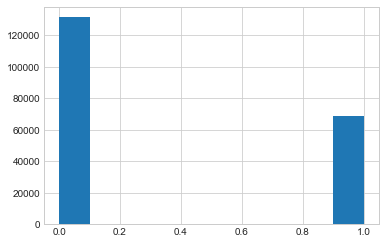

In [3]:
train_df.gen_target.hist()

In [4]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [5]:
size = 224

In [7]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=128, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,0,0
Path: /home/giles/Documents/kaggle/higgsml/images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,1
Path: /home/giles/Documents/kaggle/higgsml/images;

Test: None

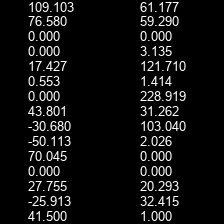

In [9]:
data.train_ds[0][0]

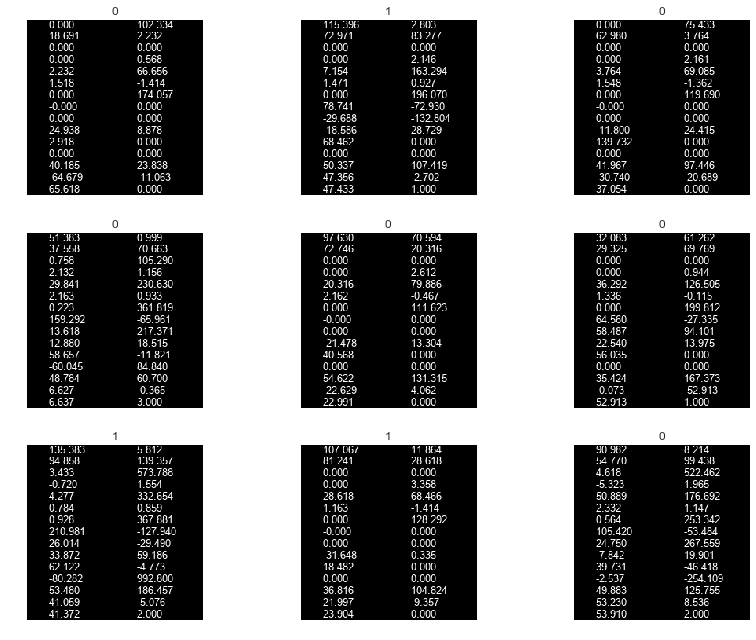

In [10]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


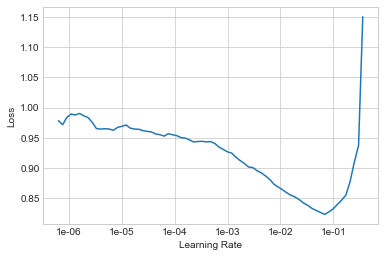

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.472384,0.449475,0.206600,05:18
1,0.424661,0.401315,0.179625,05:11
2,0.407572,0.389909,0.174675,05:04
3,0.388012,0.386691,0.172700,05:05


In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [20]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


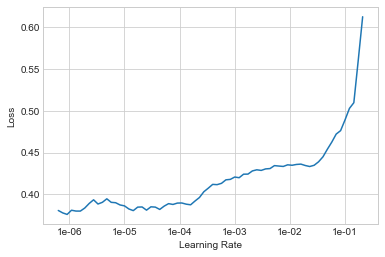

In [18]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.392559,0.384585,0.171450,06:48
1,0.379548,0.378757,0.168950,06:46
2,0.356001,0.379521,0.170100,06:47
3,0.334355,0.381848,0.170650,06:47


In [22]:
learn.save('stage-2')

In [23]:
learn.load('stage-2');

In [24]:
learn.export()

## Interpretation

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

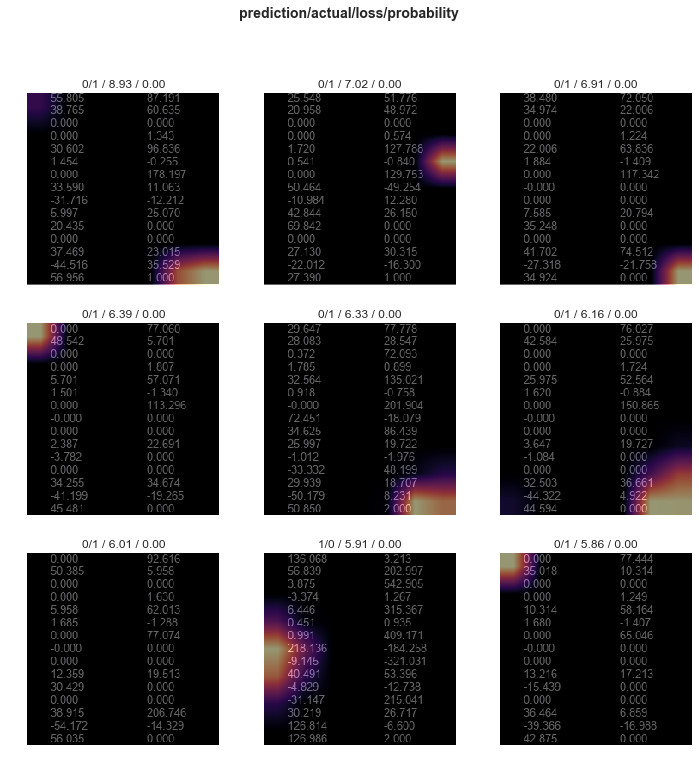

In [26]:
interp.plot_top_losses(9)

### Heatmap
Copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [27]:
x,y = data.valid_ds[1]

In [28]:
m = learn.model.eval();

In [29]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [30]:
from fastai.callbacks.hooks import *

In [31]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [32]:
hook_a,hook_g = hooked_backward()

In [33]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [34]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [35]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,size,size,0),
              interpolation='bilinear', cmap='magma');

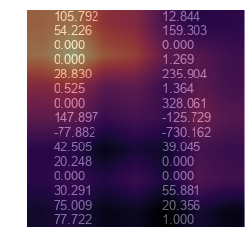

In [36]:
show_heatmap(avg_acts)

### Grad-CAM

In [37]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 7, 7]), torch.Size([512]))

In [38]:
mult = (acts*grad_chan[...,None,None]).mean(0)

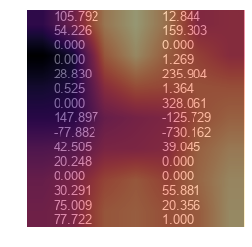

In [39]:
show_heatmap(mult)

# Inference

## Validation

In [40]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,76.418,3.938999,44.337,168.734000,0.067,210.277,3.883,1.068,0.751001,...,-3.623931,180.95699,62.353,7.814439,82.096670,4.519875,82.221,2.0,0,1.454848
1,1,117.480,69.139000,72.346,129.037000,0.000,0.000,0.000,1.804,2.276000,...,0.000000,0.00000,41.964,46.263588,16.064648,71.238120,73.027,1.0,1,0.002653
2,2,103.450,90.002000,65.904,0.491999,0.000,0.000,0.000,2.596,0.492000,...,0.000000,0.00000,54.363,0.815476,-36.469048,-10.787287,38.031,0.0,0,4.931831
3,3,80.053,23.260000,60.928,5.947001,0.000,0.000,0.000,2.693,5.947001,...,0.000000,0.00000,26.376,17.738108,2.664624,-12.638150,12.916,0.0,0,1.681611
4,4,77.740,6.090001,31.563,181.801000,2.673,405.235,-1.146,0.948,9.149000,...,-63.007470,-36.15752,29.917,15.623349,119.094765,12.189971,119.717,2.0,0,0.309795


In [41]:
val_lst = ImageList.from_df(val_df, IMG_PATH/'images', folder='val', suffix='.png')

In [42]:
learn = load_learner(IMG_PATH/'images', test=val_lst)

In [43]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [44]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


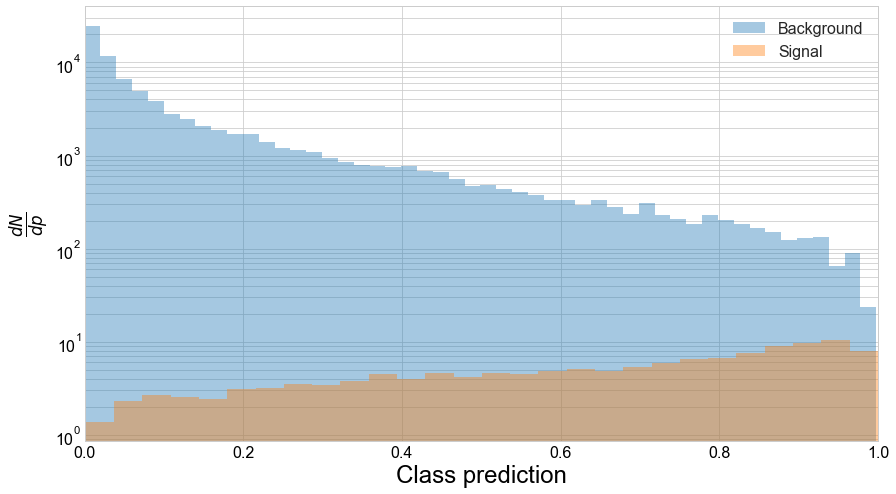

In [45]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8770687580108643 corresponds to AMS of 3.0186210708966605
Maximum AMS for data is 3.0983817295389504 at cut of 0.8430604338645935


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


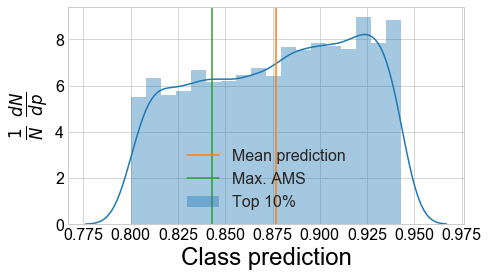

In [46]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.8)

## Test

In [47]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_subleading_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,0.000,79.311,15.349003,17.677000,0.000,0.000,0.000,0.551,17.677,...,0.000000,29.777,30.694746,-52.239800,11.003113,53.386,0.0,0,2.452419,1
1,1,0.000,73.115,45.672000,3.562998,0.000,0.000,0.000,1.774,3.563,...,0.000000,35.750,2.504540,-34.759644,-19.791088,39.999,0.0,0,2.592894,1
2,2,117.983,85.147,86.926000,20.316000,0.000,0.000,0.000,2.756,20.316,...,0.000000,48.663,63.305720,-36.938477,-6.782474,37.556,0.0,0,1.210298,1
3,3,102.694,8.028,48.651000,158.137000,3.249,443.651,-2.480,1.522,1.923,...,-125.610725,35.641,21.808634,98.654140,13.399811,99.560,2.0,1,0.000840,1
4,4,65.206,4.119,42.107000,164.894000,0.367,101.432,0.901,0.744,24.674,...,96.925990,45.041,36.688750,58.347786,-4.677806,58.535,2.0,0,0.806562,1


In [48]:
test_lst = ImageList.from_df(test_df, IMG_PATH/'images', folder='test', suffix='.png')

In [49]:
learn = load_learner(IMG_PATH/'images', test=test_lst)

In [50]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [52]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,0.000,79.311,15.349003,17.677000,0.000,0.000,0.000,0.551,17.677,...,29.777,30.694746,-52.239800,11.003113,53.386,0.0,0,2.452419,1,0.002819
1,1,0.000,73.115,45.672000,3.562998,0.000,0.000,0.000,1.774,3.563,...,35.750,2.504540,-34.759644,-19.791088,39.999,0.0,0,2.592894,1,0.010720
2,2,117.983,85.147,86.926000,20.316000,0.000,0.000,0.000,2.756,20.316,...,48.663,63.305720,-36.938477,-6.782474,37.556,0.0,0,1.210298,1,0.186011
3,3,102.694,8.028,48.651000,158.137000,3.249,443.651,-2.480,1.522,1.923,...,35.641,21.808634,98.654140,13.399811,99.560,2.0,1,0.000840,1,0.949687
4,4,65.206,4.119,42.107000,164.894000,0.367,101.432,0.901,0.744,24.674,...,45.041,36.688750,58.347786,-4.677806,58.535,2.0,0,0.806562,1,0.005942


In [53]:
score_test_df(test_df, cut)

Public:Private AMS: 2.7829296522644444 : 2.8251422289209294


(2.7829296522644444, 2.8251422289209294)